# Libraries

In [ ]:
import numpy as np

from scipy.stats import pearsonr
from scipy.stats import spearmanr

import matplotlib.pyplot as plt
import matplotlib as mpl

import pandas as pd

import torch

from pathlib import Path

In [ ]:
# Set the font family for math symbols
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Times New Roman"
plt.rcParams["mathtext.it"] = "Times New Roman:italic"
plt.rcParams["mathtext.bf"] = "Times New Roman:bold"

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# Fcn

In [ ]:
# def split_into_chunks(arr, chunk_size):
#     return [arr[i:i + chunk_size] for i in range(0, len(arr), chunk_size)]


def split_into_chunks(arr, chunk_size):
    return np.array([arr[i:i + chunk_size] for i in range(0, len(arr), chunk_size)])

# Paths

In [ ]:
home_path = Path.home()

base = home_path / 'base'
data_path = base / 'data'
ml_data_path = data_path / 'ML'
ppv_data_path = ml_data_path / 'ppv'

train_data_path = ml_data_path / 'train'

# GPU or CPU

In [7]:
# GPU or CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: ', device)

device:  cpu


In [8]:
torch.cuda.device_count()

0

# CNN

In [ ]:
cnn_data_path  = train_data_path / 'cnn'
checkpoint_path = cnn_data_path / 'checkpoint'
training_process_path = cnn_data_path / 'cnn256_split'

In [ ]:
pe_list  = ['original_vector',  'index_concate',  'index_add',  'sin_concate',  'sin_add', 'poly_concate']
pev_list = ['Original', 'Concat Index', 'Add Index', 'Concat Sinusoidal', 'Add Sinusoidal', 'Concat Polynomial']
npe        = len(pe_list)

prex = 'cnn_'
suffix = '_c256'

file_list  = [training_process_path / (prex + x + suffix + '.csv') for x in pe_list]
file_list

In [ ]:
valid_mean_mse_arr = np.zeros(npe)
valid_std_mse_arr = np.zeros(npe)

test_mean_mse_arr = np.zeros(npe)
test_std_mse_arr = np.zeros(npe)

valid_mean_mse_arr_list = []
test_mean_mse_arr_list  = []

for (i, csvfile) in enumerate(file_list):
  df = pd.read_csv(csvfile)

  valid_mse_values = np.sqrt(df.valid_err.values)
  test_mse_values  = np.sqrt(df.test_err.values)

  valid_mean_mse_arr_list.append(valid_mse_values)
  test_mean_mse_arr_list.append(test_mse_values)

  valid_mean_mse = np.median(valid_mse_values)
  valid_std_mse  = valid_mse_values.std()

  test_mean_mse  = np.median(test_mse_values)
  test_std_mse   = test_mse_values.std()

  valid_mean_mse_arr[i] = valid_mean_mse
  valid_std_mse_arr[i] = valid_std_mse

  test_mean_mse_arr[i] = test_mean_mse
  test_std_mse_arr[i] = test_std_mse

In [13]:
for m,s,xi in zip(valid_mean_mse_arr, valid_std_mse_arr, pev_list):
  print(f"Valid MSE: Mean={m:.6f}, std={s:.6f}  for {xi}")

Valid MSE: Mean=0.085850, std=0.001433  for Original
Valid MSE: Mean=0.084992, std=0.000906  for Concat Index
Valid MSE: Mean=0.085240, std=0.000981  for Add Index
Valid MSE: Mean=0.080908, std=0.002588  for Concat Sinusoidal
Valid MSE: Mean=0.083015, std=0.000554  for Add Sinusoidal
Valid MSE: Mean=0.080896, std=0.000618  for Concat Polynomial


In [14]:
for m,s,xi in zip(test_mean_mse_arr, test_std_mse_arr, pev_list):
  print(f"Test MSE: Mean={m:.6f}, std={s:.6f}  for {xi}")

Test MSE: Mean=0.086760, std=0.001324  for Original
Test MSE: Mean=0.085176, std=0.000700  for Concat Index
Test MSE: Mean=0.085708, std=0.001175  for Add Index
Test MSE: Mean=0.084243, std=0.000893  for Concat Sinusoidal
Test MSE: Mean=0.082421, std=0.000966  for Add Sinusoidal
Test MSE: Mean=0.084282, std=0.000954  for Concat Polynomial


In [ ]:
file_list  = [training_process_path / (prex + x + '_process' + suffix + '.csv') for x in pe_list]
file_list

In [19]:
k = 2
pev = pev_list[k]
process_df = pd.read_csv(training_process_path / file_list[k])
print(process_df.shape)
process_df.head()

(600, 4)


,epoch,train_err,valid_err,test_err
0,0,0.035087,0.025555,0.021251
1,1,0.024675,0.019450,0.016604
2,2,0.021841,0.017667,0.015391
3,3,0.019186,0.224177,0.225951
4,4,0.017824,0.016555,0.014245


In [ ]:
process_train_err    = np.sqrt(process_df['train_err'].values)
process_validate_err = np.sqrt(process_df['valid_err'].values)
process_test_err     = np.sqrt(process_df['test_err'].values)
epochs               = process_df['epoch'].values

In [22]:
nepochs = epochs.max() + 1
nepochs

60

In [23]:
epoch_chunks = split_into_chunks(epochs, nepochs)
process_train_err_chunks    = split_into_chunks(process_train_err, nepochs)
process_validate_err_chunks = split_into_chunks(process_validate_err, nepochs)
process_test_err_chunks     = split_into_chunks(process_test_err, nepochs)

In [ ]:
rp, p_value = spearmanr(process_train_err, process_validate_err)

print(f"Pearson Correlation Coefficient: {rp}")
print(f"P-value: {p_value}")

Pearson Correlation Coefficient: 0.906195072764091
P-value: 1.0508332606396766e-225


In [30]:
process_train_rmse_mean = np.zeros((10, npe))
process_valid_rmse_mean = np.zeros((10, npe))
process_test_rmse_mean  = np.zeros((10, npe))

mean_train_mse_cnn = np.zeros(nepochs)
mean_valid_mse_cnn = np.zeros(nepochs)
mean_test_mse_cnn  = np.zeros(nepochs)

# Loop through your scatter plot data and create subplots
for i, (xfile_list, pev) in enumerate(zip(file_list, pev_list)):
    process_df = pd.read_csv(training_process_path / xfile_list)

    process_train_err    = np.sqrt(process_df['train_err'].values)
    process_validate_err = np.sqrt(process_df['valid_err'].values)
    process_test_err     = np.sqrt(process_df['test_err'].values)
    epochs               = process_df['epoch'].values

    epoch_chunks = split_into_chunks(epochs, nepochs)
    process_train_err_chunks    = split_into_chunks(process_train_err, nepochs)
    process_validate_err_chunks = split_into_chunks(process_validate_err, nepochs)
    process_test_err_chunks     = split_into_chunks(process_test_err, nepochs)

    process_train_rmse_mean[:,i] = np.asarray([np.median(x) for x in process_train_err_chunks])
    process_valid_rmse_mean[:,i] = np.asarray([np.median(x) for x in process_validate_err_chunks])
    process_test_rmse_mean[:,i]  = np.asarray([np.median(x) for x in process_test_err_chunks])

    mean_process_train_err    = process_train_err_chunks.mean(axis=0)
    mean_process_validate_err = process_validate_err_chunks.mean(axis=0)
    mean_process_test_err     = process_test_err_chunks.mean(axis=0)

    mean_train_mse_cnn += mean_process_train_err
    mean_valid_mse_cnn += mean_process_validate_err
    mean_test_mse_cnn += mean_process_test_err
# End - for
mean_train_mse_cnn = mean_train_mse_cnn / npe
mean_valid_mse_cnn = mean_valid_mse_cnn / npe
mean_test_mse_cnn  = mean_test_mse_cnn / npe

# Read the CSV: CNN-Transformer

In [ ]:
ctrans_data_path = train_data_path / 'ctrans'
checkpoint_path = ctrans_data_path / 'checkpoint'

In [ ]:
pe_list  = ['original_vector',  'index_concate',  'index_add',  'sin_concate',  'sin_add', 'poly_concate', 'learnable_PEV']
pev_list = ['Original', 'Concat Index', 'Add Index', 'Concat Sinusoidal', 'Add Sinusoidal', 'Concat Polynomial', 'Learnable']
npe = len(pe_list)
pe_list

In [ ]:
prex   = 'ct_'
suffix = '_c256'

training_process_path = ctrans_data_path / 'training_process' / 'c256'
file_list  = [training_process_path / (x + '.csv') for x in pe_list]

In [ ]:
ct_valid_mean_mse_arr = np.zeros(npe)
ct_valid_std_mse_arr = np.zeros(npe)

ct_test_mean_mse_arr = np.zeros(npe)
ct_test_std_mse_arr = np.zeros(npe)

ct_valid_mean_mse_arr_list = []
ct_test_mean_mse_arr_list  = []

for (i, csvfile) in enumerate(file_list):
  df = pd.read_csv(csvfile)

  ct_valid_mse_values = np.sqrt(df.valid_err.values)
  ct_test_mse_values  = np.sqrt(df.test_err.values)

  ct_valid_mean_mse_arr_list.append(ct_valid_mse_values)
  ct_test_mean_mse_arr_list.append(ct_test_mse_values)

  ct_valid_mean_mse = np.median(ct_valid_mse_values)
  ct_valid_std_mse  = ct_valid_mse_values.std()

  ct_test_mean_mse  = np.median(ct_test_mse_values)
  ct_test_std_mse   = ct_test_mse_values.std()

  ct_valid_mean_mse_arr[i] = ct_valid_mean_mse
  ct_valid_std_mse_arr[i]  = ct_valid_std_mse

  ct_test_mean_mse_arr[i] = ct_test_mean_mse
  ct_test_std_mse_arr[i] = ct_test_std_mse

In [39]:
for m,s,xi in zip(ct_valid_mean_mse_arr, ct_valid_std_mse_arr, pev_list):
  print(f"Valid MSE: Mean={m:.6f}, std={s:.6f}  for {xi}")

Valid MSE: Mean=0.079554, std=0.001853  for Original
Valid MSE: Mean=0.081057, std=0.001573  for Concat Index
Valid MSE: Mean=0.078709, std=0.002885  for Add Index
Valid MSE: Mean=0.083327, std=0.002918  for Concat Sinusoidal
Valid MSE: Mean=0.079715, std=0.001735  for Add Sinusoidal
Valid MSE: Mean=0.078649, std=0.002599  for Concat Polynomial
Valid MSE: Mean=0.079674, std=0.003232  for Learnable


In [40]:
for m,s,xi in zip(ct_test_mean_mse_arr, ct_test_std_mse_arr, pev_list):
  print(f"Test MSE: Mean={m:.6f}, std={s:.6f}  for {xi}")

Test MSE: Mean=0.079547, std=0.001893  for Original
Test MSE: Mean=0.077652, std=0.001538  for Concat Index
Test MSE: Mean=0.081610, std=0.003322  for Add Index
Test MSE: Mean=0.079137, std=0.002411  for Concat Sinusoidal
Test MSE: Mean=0.076842, std=0.001520  for Add Sinusoidal
Test MSE: Mean=0.078770, std=0.002948  for Concat Polynomial
Test MSE: Mean=0.080684, std=0.002753  for Learnable


In [ ]:
file_list  = [training_process_path / (x + '_process' + '.csv') for x in pe_list]
file_list

In [44]:
k = 2
pev = pev_list[k]
process_df = pd.read_csv(training_process_path / file_list[k])
print(process_df.shape)
process_df.head()

(600, 4)


,epoch,train_err,valid_err,test_err
0,0,0.049904,0.030582,0.033241
1,1,0.034214,0.026698,0.028901
2,2,0.029799,0.021613,0.023977
3,3,0.027742,0.021686,0.024445
4,4,0.025082,0.018689,0.020931


In [ ]:
proc_train_err    = np.sqrt(process_df['train_err'].values)
proc_validate_err = np.sqrt(process_df['valid_err'].values)
proc_test_err     = np.sqrt(process_df['test_err'].values)
epochs            = process_df['epoch'].values

In [46]:
nepochs = epochs.max() + 1
nepochs

60

In [47]:
epoch_chunks = split_into_chunks(epochs, nepochs)
proc_train_err_chunks    = split_into_chunks(proc_train_err, nepochs)
proc_validate_err_chunks = split_into_chunks(proc_validate_err, nepochs)
proc_test_err_chunks     = split_into_chunks(proc_test_err, nepochs)

In [51]:
proc_train_rmse_mean = np.zeros((10, npe))
proc_valid_rmse_mean = np.zeros((10, npe))
proc_test_rmse_mean  = np.zeros((10, npe))


mean_train_mse_ct = np.zeros(nepochs)
mean_valid_mse_ct = np.zeros(nepochs)
mean_test_mse_ct  = np.zeros(nepochs)

# Loop through your scatter plot data and create subplots
for i, (xfile_list, pev) in enumerate(zip(file_list, pev_list)):
    proc_df = pd.read_csv(training_process_path / xfile_list)

    proc_train_err    = np.sqrt(proc_df['train_err'].values)
    proc_validate_err = np.sqrt(proc_df['valid_err'].values)
    proc_test_err     = np.sqrt(proc_df['test_err'].values)
    epochs               = proc_df['epoch'].values

    epoch_chunks = split_into_chunks(epochs, nepochs)
    proc_train_err_chunks    = split_into_chunks(proc_train_err, nepochs)
    proc_validate_err_chunks = split_into_chunks(proc_validate_err, nepochs)
    proc_test_err_chunks     = split_into_chunks(proc_test_err, nepochs)

    proc_train_rmse_mean[:,i] = np.asarray([np.median(x) for x in proc_train_err_chunks])
    proc_valid_rmse_mean[:,i] = np.asarray([np.median(x) for x in proc_validate_err_chunks])
    proc_test_rmse_mean[:,i]  = np.asarray([np.median(x) for x in proc_test_err_chunks])

    mean_process_train_err    = np.median(process_train_err_chunks, axis=0) # process_train_err_chunks.mean(axis=0)
    mean_process_validate_err = np.median(process_validate_err_chunks, axis=0) # process_validate_err_chunks.mean(axis=0)
    mean_process_test_err     = np.median(process_test_err_chunks, axis=0) # process_test_err_chunks.mean(axis=0)

    mean_train_mse_ct += mean_process_train_err
    mean_valid_mse_ct += mean_process_validate_err
    mean_test_mse_ct += mean_process_test_err
# End - for
mean_train_mse_ct = mean_train_mse_ct / npe
mean_valid_mse_ct = mean_valid_mse_ct / npe
mean_test_mse_ct  = mean_test_mse_ct / npe

# Comparison

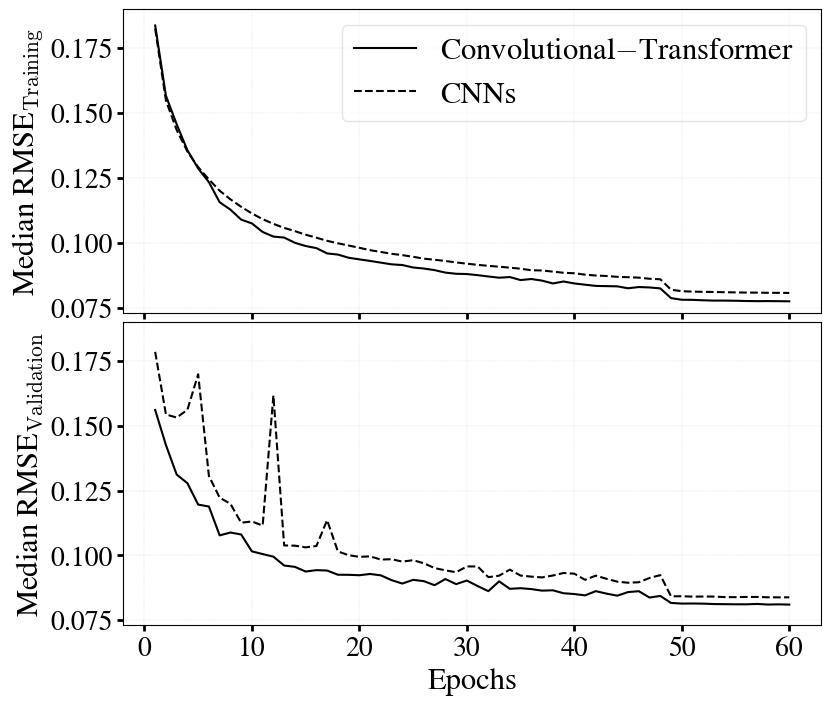

In [ ]:
# Plot
fig, (ax, ax1) = plt.subplots(figsize=(9,8), nrows=2, sharex=True)


ax.plot(epoch_chunks[0]+1, mean_train_mse_ct, 'k-', label=r'Convolutional$-$Transformer')
ax.plot(epoch_chunks[0]+1, mean_train_mse_cnn, 'k--', label=f'CNNs')

# Add axes labels
ax.set_xlabel(r'Epochs', fontsize=22)
ax.set_ylabel(r"Median RMSE$_\mathrm{Training}$", fontsize=22)

ax.tick_params(axis='x', labelsize=20, pad=4)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)
ax.set_ylim(0.073, 0.19)


ax.legend(loc='upper right', fancybox=True, framealpha=0.5, labelcolor='k', fontsize=22)
ax.grid(True, linestyle='--', linewidth=0.25, color='lightgray', zorder=-10)



#
ax1.plot(epoch_chunks[0]+1, mean_valid_mse_ct, 'k-', label=f'CNN$-$Transformer')
ax1.plot(epoch_chunks[0]+1, mean_valid_mse_cnn, 'k--', label=f'CNNs')

# Add axes labels
ax1.set_xlabel(r'Epochs', fontsize=22)
ax1.set_ylabel(r"Median RMSE$_\mathrm{Validation}$", fontsize=22)


ax1.tick_params(axis='x', labelsize=20, pad=4)
ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=4)
ax1.tick_params(which='minor', length=2)
ax1.set_ylim(0.073, 0.19)

ax1.grid(True, linestyle='--', linewidth=0.25, color='lightgray', zorder=-10)


# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0,
                    hspace=0.03
                    )

plt.show()

To the Abstract: On average, how much better?

In [62]:
ct_med_rmse = np.mean(mean_valid_mse_ct)
cnn_med_rmse = np.mean(mean_valid_mse_cnn)
tmp = 100.*(cnn_med_rmse - ct_med_rmse)/ct_med_rmse
print(ct_med_rmse)
print(cnn_med_rmse)
print('On average, how much better?', tmp, '%')

0.09336918571402537
0.10237228109607655
On average, how much better? 9.642469636209732


# End